***Import library***

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

***Hyper Parameters***

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

batch_size = 8
learning_rate = 0.001
num_epochs = 800

normal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\normal'
abnormal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\abnormal'

***Load Datasets***

In [3]:
normal_set = datasets.ImageFolder(
    normal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

abnormal_set = datasets.ImageFolder(
    abnormal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

train_set, test_set = torch.utils.data.random_split(normal_set, [len(normal_set) - 80, 80])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True)
normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=batch_size,shuffle=True)

print(f"Number of normal data : {len(normal_set)}")
print(f"Number of abnormal data : {len(abnormal_set)}")

Number of normal data : 296
Number of abnormal data : 2100


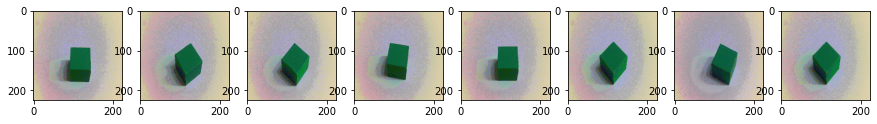

In [4]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(batch_size), images, labels):
    numpy_img = np.transpose(img.numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, batch_size, i+1)
    ax.imshow(numpy_img)
plt.show()

**AutoEncoder**

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
            nn.ReLU())
        
        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer3 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
            nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.cnn_layer3(output)        
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        output = self.tran_cnn_layer3(output)
        
        return output
    
model = ConvAutoEncoder()
model.to(device)

ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer3): Sequential(
    (0): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

***Train & Test***

In [7]:
BEST_MODEL_PATH = "CAE_best_model.pth"

best_loss = 1.0
train_losses = []
test_losses = []


for epoch in range(num_epochs):
    
    ########### Train ###########
    train_loss = 0
    for i, (X_train, _) in enumerate(train_loader):
        X_train = X_train.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, X_train)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_losses.append(train_loss / len(train_loader))
       
    
    ########### Test ###########  
    with torch.no_grad():
        test_loss = 0
        for i, (X_test, _) in enumerate(test_loader):
            X_test = X_test.to(device)
            
            outputs = model(X_test)
            loss = criterion(outputs, X_test)
            test_loss += loss.item()   
            
        test_losses.append(test_loss / len(test_loader))
        
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}/{num_epochs}',
              'Train loss: {:.5f}..'.format(train_loss / len(train_loader) * batch_size), 
              'Test loss: {:.5f}..'.format(test_loss / len(test_loader) * batch_size))
                
########### Save Model ###########
torch.save(model.state_dict(), BEST_MODEL_PATH)

Epoch: 0/800 Train loss: 0.36439.. Test loss: 0.24217..
Epoch: 10/800 Train loss: 0.02310.. Test loss: 0.02222..
Epoch: 20/800 Train loss: 0.01603.. Test loss: 0.01588..
Epoch: 30/800 Train loss: 0.01340.. Test loss: 0.01330..
Epoch: 40/800 Train loss: 0.01202.. Test loss: 0.01206..
Epoch: 50/800 Train loss: 0.01145.. Test loss: 0.01148..
Epoch: 60/800 Train loss: 0.01108.. Test loss: 0.01112..
Epoch: 70/800 Train loss: 0.01076.. Test loss: 0.01080..
Epoch: 80/800 Train loss: 0.01047.. Test loss: 0.01052..
Epoch: 90/800 Train loss: 0.01021.. Test loss: 0.01024..
Epoch: 100/800 Train loss: 0.00956.. Test loss: 0.00952..
Epoch: 110/800 Train loss: 0.00918.. Test loss: 0.00920..
Epoch: 120/800 Train loss: 0.00900.. Test loss: 0.00904..
Epoch: 130/800 Train loss: 0.00886.. Test loss: 0.00888..
Epoch: 140/800 Train loss: 0.00874.. Test loss: 0.00877..
Epoch: 150/800 Train loss: 0.00864.. Test loss: 0.00867..
Epoch: 160/800 Train loss: 0.00855.. Test loss: 0.00858..
Epoch: 170/800 Train loss

***Losses of normal & abnormal data***

In [8]:
model.eval()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    #normal_loss = loss.item()
    normal_losses.append(loss.item())
    
    print(f'Normal loss: {loss.item()}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs,abnormal_img)
    abnormal_losses.append(loss.item())
    
    print(f'Abnormal loss: {loss.item()}')

Normal loss: 0.0008653324912302196
Normal loss: 0.0009296932839788496
Normal loss: 0.0009271523449569941
Normal loss: 0.0009267820860259235
Normal loss: 0.00083258276572451
Normal loss: 0.0008502301061525941
Normal loss: 0.0008757250034250319
Normal loss: 0.0009273636969737709
Normal loss: 0.0009404232259839773
Normal loss: 0.0008873828919604421
Normal loss: 0.0009471101802773774
Normal loss: 0.0009691152372397482
Normal loss: 0.0009632873698137701
Normal loss: 0.0009081742609851062
Normal loss: 0.0009068595245480537
Normal loss: 0.00093807652592659
Normal loss: 0.0009304634295403957
Normal loss: 0.0008806355181150138
Normal loss: 0.0009209365234710276
Normal loss: 0.0009735999046824872
Normal loss: 0.0008839248912408948
Normal loss: 0.0009200682397931814
Normal loss: 0.0009130361140705645
Normal loss: 0.0009538575541228056
Normal loss: 0.0009778478415682912
Normal loss: 0.0008886410505510867
Normal loss: 0.0009078713483177125
Normal loss: 0.0009144483483396471
Normal loss: 0.000900011

Abnormal loss: 0.0033556241542100906
Abnormal loss: 0.0039577484130859375
Abnormal loss: 0.0037417784333229065
Abnormal loss: 0.003242986975237727
Abnormal loss: 0.0034435661509633064
Abnormal loss: 0.004194865934550762
Abnormal loss: 0.003490195609629154
Abnormal loss: 0.00433371402323246
Abnormal loss: 0.004054591525346041
Abnormal loss: 0.004758425056934357
Abnormal loss: 0.00363233988173306
Abnormal loss: 0.003923212643712759
Abnormal loss: 0.0036756894551217556
Abnormal loss: 0.0038243455346673727
Abnormal loss: 0.003572117304429412
Abnormal loss: 0.004440310876816511
Abnormal loss: 0.003848819062113762
Abnormal loss: 0.004439502954483032
Abnormal loss: 0.004451326094567776
Abnormal loss: 0.0032020912040024996
Abnormal loss: 0.004864185582846403
Abnormal loss: 0.0024398232344537973
Abnormal loss: 0.0038820647168904543
Abnormal loss: 0.00449163094162941
Abnormal loss: 0.004045921843498945
Abnormal loss: 0.003285540034994483
Abnormal loss: 0.004267471842467785
Abnormal loss: 0.00388

***Graph***

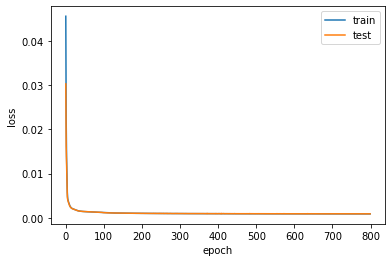

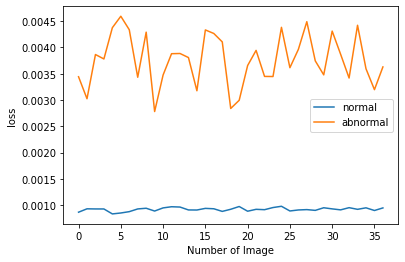

In [9]:
plt.figure(1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.show()

plt.figure(2)
plt.xlabel('Number of Image')
plt.ylabel('loss')
plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.legend()
plt.show()

***Result***

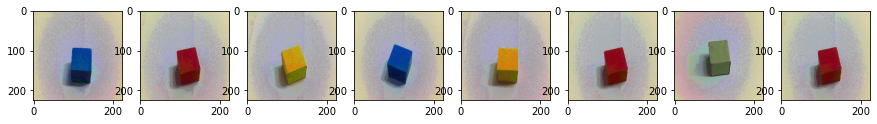

In [10]:
abnormal_images, abnormal_labels = next(iter(abnormal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(batch_size), abnormal_images, abnormal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, batch_size, i+1)
    ax.imshow(numpy_img)
plt.show()

C:\Users\WorkStation\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([8, 3, 224, 224])) that is different to the input size (torch.Size([3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.011984352953732014
0.008501927368342876
0.010231751948595047
0.012271760031580925
0.010115875862538815
0.008341529406607151
0.01619362272322178
0.008427407592535019


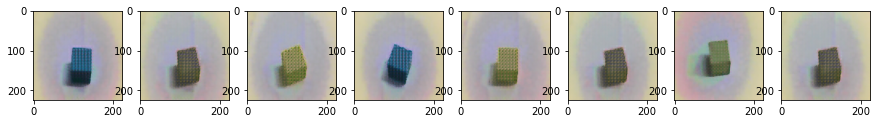

In [11]:
model.cpu()
abnormal_output = model(abnormal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(batch_size), abnormal_output, abnormal_labels):
    loss = criterion(img, abnormal_images)
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, batch_size, i+1)
    ax.imshow(numpy_img)
plt.show()